# Ethereum Transaction Anomaly Detection

This notebook explores anomaly detection on Ethereum transactions using:
- Isolation Forest
- DBSCAN

We'll compare their performance and visualize the results.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN



# Custom imports
from src.preprocessing import preprocess_transactions
from src.modeling import anomaly_detection_pipeline, prepare_features, tune_isolation_forest, tune_dbscan

# Plotting settings
plt.style.use('seaborn')
sns.set_palette('Set2')
%matplotlib inline

/var/folders/7h/ytvk33c10tndb37v7_kzbm_w0000gp/T/ipykernel_14685/1605025780.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Load and Prepare Data

In [2]:
# Load most recent raw data file
raw_data_path = max(Path('../data/raw').glob('transactions_*.csv'))
df_raw = pd.read_csv(raw_data_path)

print(f"Loaded {len(df_raw)} transactions from {raw_data_path.name}")
df_raw.head()

Loaded 17817 transactions from transactions_20250115_204200.csv


,hash,block_number,from_address,to_address,value,gas,block_timestamp,gas_price,transaction_fee
0,0xfe51bc8dbefc05d4049ec95d57faae442c41d2edb338...,21632038,0x576ee2ad743b6daDA280e88261Afb3e107BDAED9,0x3328F7f4A1D1C57c35df56bBf0c9dCAFCA309C49,0.100000,471312,1736970071,29.051617,1.369238e+07
1,0xa27eba8db4eb5dba74753315123127c8c28b1ba5e792...,21632038,0x41f7A9b39498f32adE0c8691866EE751b4b622EA,0x8934347DeE1DCd76D81eb38A6E3Ce7CaB5bd9c53,17.296497,21000,1736970071,24.200000,5.082000e+05
2,0xe93e09f5939982d965866dc6ccdd5bec3b8f1a01a02f...,21632038,0x7A6e99771575A5ac3D2796b7Ee0ad0Cce36a29Df,0x0eF56548dAF2eB21792F7d70D0A7D72c37F02683,0.001203,21000,1736970071,24.200000,5.082000e+05
3,0x264e837c8e614326dd750114a6e88538b207b48f989d...,21632038,0xa826e12fC46A4b2bff0107E6a3B787465f033F6c,0x5BF9A6E2859959689058872670bAcCda50533f38,0.029422,21000,1736970071,22.000000,4.620000e+05
4,0x10fe6c22bc08c330015696191f7949d5cca2cc1c868b...,21632038,0x9acbB72Cf67103A30333A32CD203459c6a9c3311,0xcf0C122c6b73ff809C693DB761e7BaeBe62b6a2E,0.000000,90000,1736970071,21.000000,1.890000e+06


In [5]:
# Transform data and add features
df_processed = df_raw.copy()

# Drop rows with missing values in key columns
df_processed = df_processed.dropna(subset=['value', 'gas_price', 'gas'])
print(f"Remaining transactions after dropping nulls: {len(df_processed)}")

# Create derived features
df_processed['transaction_fee'] = df_processed['gas_price'] * df_processed['gas']

# Log transform numerical features to handle extreme values
for col in ['value', 'gas_price', 'gas', 'transaction_fee']:
    # Add small constant to handle zeros
    df_processed[f'log_{col}'] = np.log1p(df_processed[col])

# Calculate transaction density (number of transactions per block)
if 'block_number' in df_processed.columns:
    tx_counts = df_processed['block_number'].value_counts()
    df_processed['tx_density'] = df_processed['block_number'].map(tx_counts)

# Calculate address frequencies
from_counts = df_processed['from_address'].value_counts()
to_counts = df_processed['to_address'].value_counts()
df_processed['from_address_freq'] = df_processed['from_address'].map(from_counts)
df_processed['to_address_freq'] = df_processed['to_address'].map(to_counts)

# Calculate ratios
df_processed['value_to_gas_ratio'] = df_processed['value'] / df_processed['gas']
df_processed['fee_to_value_ratio'] = df_processed['transaction_fee'] / (df_processed['value'] + 1e-10)  # Add small constant to avoid division by zero

print("\nFeatures available:")
for col in df_processed.columns:
    print(f"- {col}")

Remaining transactions after dropping nulls: 17817

Features available:
- hash
- block_number
- from_address
- to_address
- value
- gas
- block_timestamp
- gas_price
- transaction_fee
- log_value
- log_gas_price
- log_gas
- log_transaction_fee
- tx_density
- from_address_freq
- to_address_freq
- value_to_gas_ratio
- fee_to_value_ratio


## 2. Exploratory Data Analysis

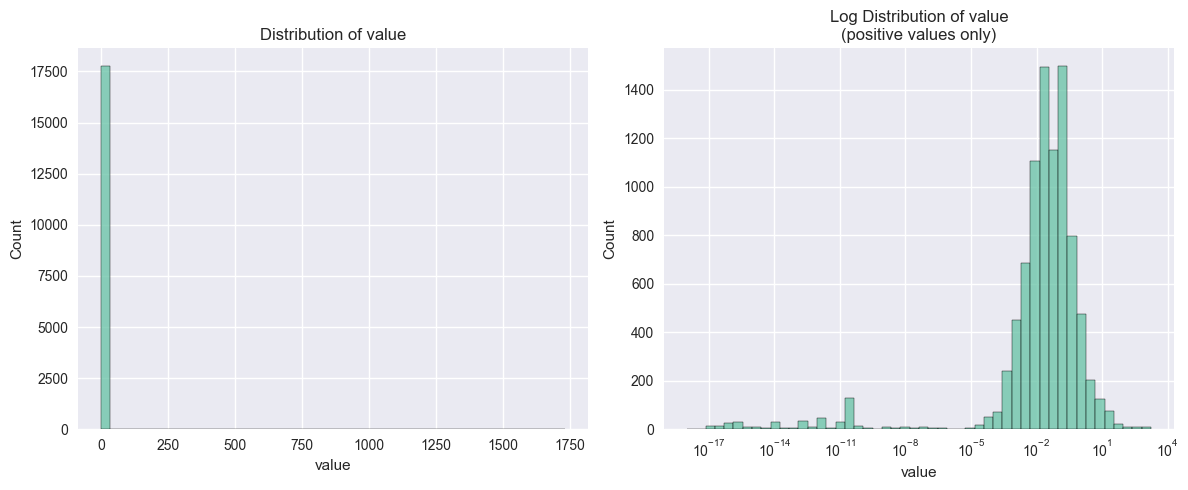

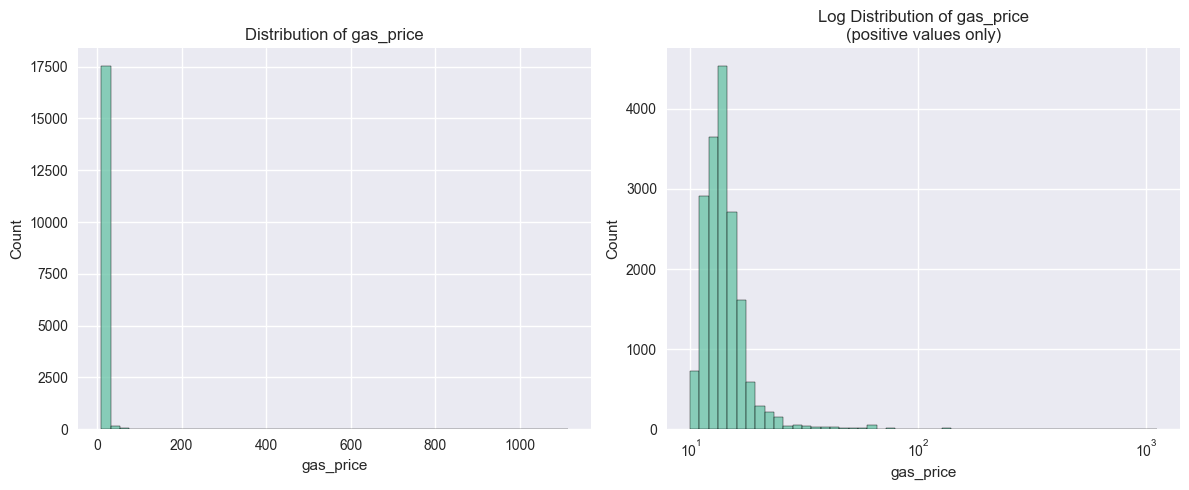

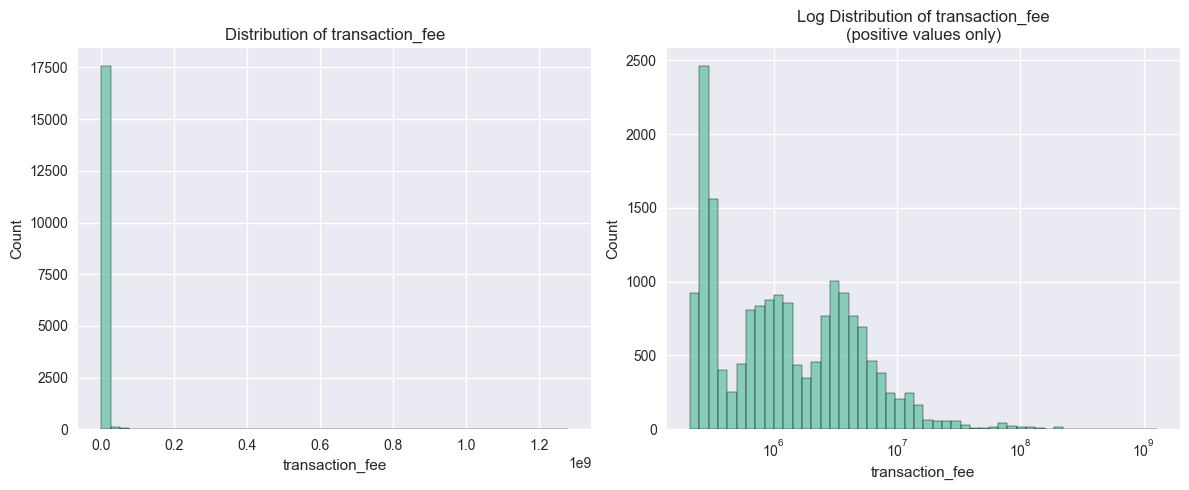

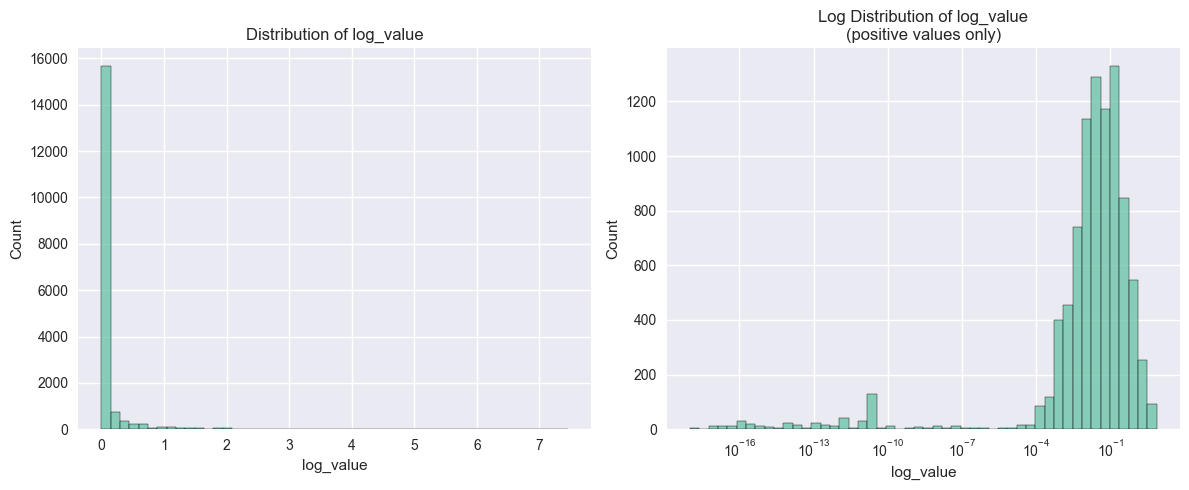

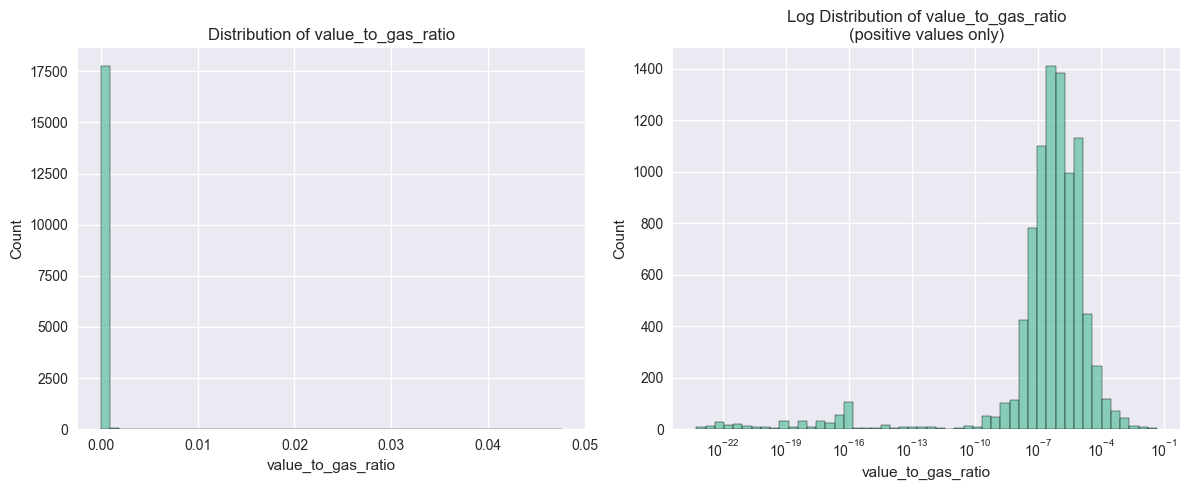

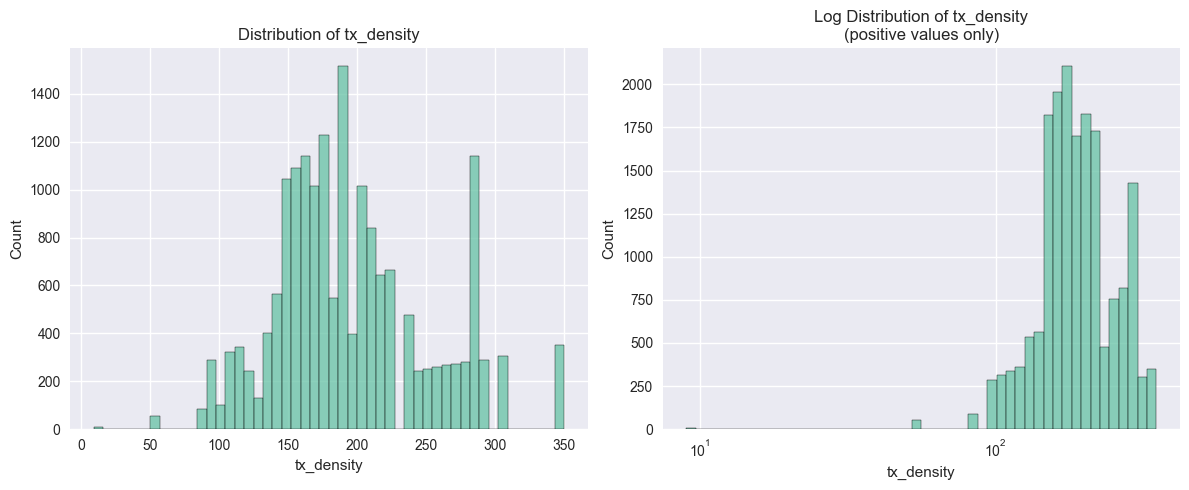

In [7]:
def plot_distribution(df, column, bins=50):
    plt.figure(figsize=(12, 5))
    
    # Regular distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column, bins=bins)
    plt.title(f'Distribution of {column}')
    
    # Log distribution plot (handle zeros and negatives)
    plt.subplot(1, 2, 2)
    # Add small constant and filter out non-positive values for log scale
    valid_data = df[df[column] > 0]
    if len(valid_data) > 0:
        sns.histplot(data=valid_data, x=column, bins=bins, log_scale=True)
        plt.title(f'Log Distribution of {column}\n(positive values only)')
    else:
        plt.text(0.5, 0.5, 'No positive values\nfor log scale', 
                ha='center', va='center')
        plt.title(f'Log Distribution of {column}')
    
    plt.tight_layout()

# Plot key features distributions
for feature in ['value', 'gas_price', 'transaction_fee']:
    plot_distribution(df_processed, feature)

# Plot derived features
for feature in ['log_value', 'value_to_gas_ratio', 'tx_density']:
    if feature in df_processed.columns:  # Only plot if feature exists
        plot_distribution(df_processed, feature)

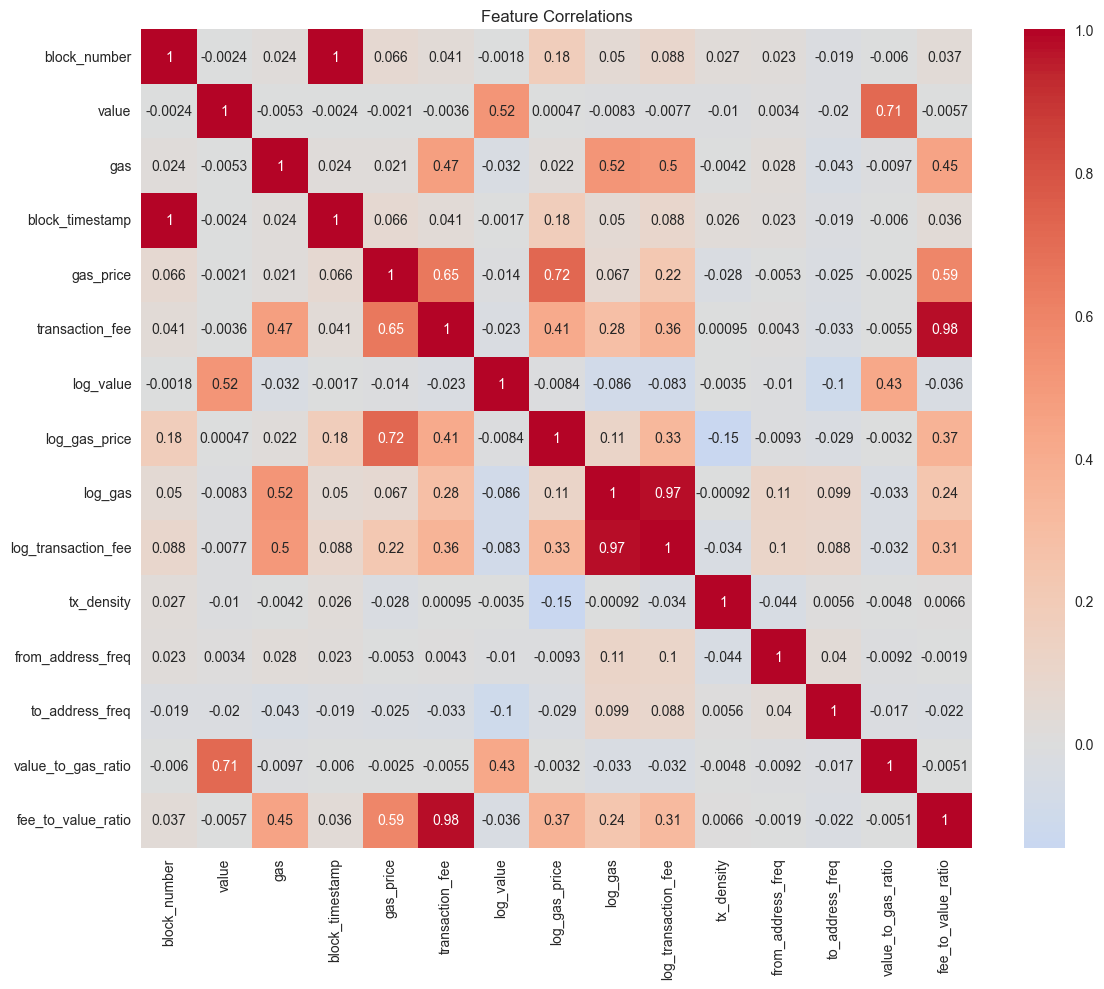

In [8]:
# Correlation heatmap of numerical features
numerical_features = df_processed.select_dtypes(include=[np.number]).columns
correlation = df_processed[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()

## 3. Hyperparameter Tuning

We'll optimize the hyperparameters for both models using cross-validation and our custom silhouette score.

In [15]:
# Prepare features for tuning
X_scaled, features_used = prepare_features(df_processed)
print(f"Features prepared for tuning: {features_used}")

# Prepare features for modeling
feature_columns = ['value', 'gas_price', 'gas', 'transaction_fee']
X = df_processed[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Features prepared for tuning: ['value', 'gas_price', 'gas']


### 3.1 Isolation Forest Tuning

We'll use GridSearchCV to find the best parameters among:
- n_estimators: [50, 100, 200]
- max_samples: [0.5, 1.0]
- contamination: [0.01, 0.02, 0.05]

In [20]:
# Define parameter grid for Isolation Forest
if_param_grid = {
    'n_estimators': [50, 100, 200],
    'contamination': [0.01, 0.05, 0.1],
    'max_samples': [100, 'auto'],
    'random_state': [42]
}

# Tune Isolation Forest
print("Starting Isolation Forest tuning...")
if_best_params = tune_isolation_forest(df_processed, if_param_grid)

print("\nBest Isolation Forest Parameters:")
for param, value in if_best_params.items():
    print(f"- {param}: {value}")

# Train final model with best parameters
if_model = IsolationForest(**if_best_params)
predictions = if_model.fit_predict(X_scaled)
anomalies = predictions == -1

print(f"\nDetected {sum(anomalies)} anomalies ({sum(anomalies)/len(anomalies)*100:.1f}% of transactions)")

Starting Isolation Forest tuning...

Best Isolation Forest Parameters:
- n_estimators: 200
- contamination: 0.01
- max_samples: auto
- random_state: 42

Detected 179 anomalies (1.0% of transactions)


### 3.2 DBSCAN Tuning

We'll use RandomizedSearchCV to find the best parameters among:
- eps: [0.3, 0.5, 0.7, 1.0]
- min_samples: [3, 5, 10]

In [21]:

# Define parameter grid for DBSCAN
dbscan_param_grid = {
    'eps': [0.1, 0.3, 0.5, 0.7],
    'min_samples': [5, 10, 15, 20]
}

# Tune DBSCAN
print("Starting DBSCAN tuning...")
dbscan_best_params = tune_dbscan(df_processed, dbscan_param_grid)

print("\nBest DBSCAN Parameters:")
for param, value in dbscan_best_params.items():
    print(f"- {param}: {value}")

# Train final model with best parameters
dbscan_model = DBSCAN(**dbscan_best_params)
predictions = dbscan_model.fit_predict(X_scaled)
anomalies = predictions == -1

print(f"\nDetected {sum(anomalies)} anomalies ({sum(anomalies)/len(anomalies)*100:.1f}% of transactions)")

Starting DBSCAN tuning...

Best DBSCAN Parameters:
- eps: 0.7
- min_samples: 5

Detected 82 anomalies (0.5% of transactions)


### 3.3 Compare Tuned Models

In [22]:
# Get predictions from both models
if_predictions = if_model.predict(X_scaled)
if_labels = (if_predictions == -1).astype(int)  # Convert to binary (1 for anomalies, 0 for normal)

dbscan_predictions = dbscan_model.fit_predict(X_scaled)
dbscan_labels = (dbscan_predictions == -1).astype(int)  # Convert to binary

# Compare results
results_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'DBSCAN'],
    'Anomalies Detected': [sum(if_labels), sum(dbscan_labels)],
    'Anomaly Percentage': [sum(if_labels)/len(if_labels)*100, sum(dbscan_labels)/len(dbscan_labels)*100]
})

print("Model Comparison after Tuning:")
print(results_df.to_string(index=False))

# Calculate agreement between models
agreement = (if_labels == dbscan_labels).mean() * 100
print(f"\nModels agree on {agreement:.2f}% of transactions")

Model Comparison after Tuning:
           Model  Anomalies Detected  Anomaly Percentage
Isolation Forest                 179            1.004658
          DBSCAN                  82            0.460235

Models agree on 99.35% of transactions


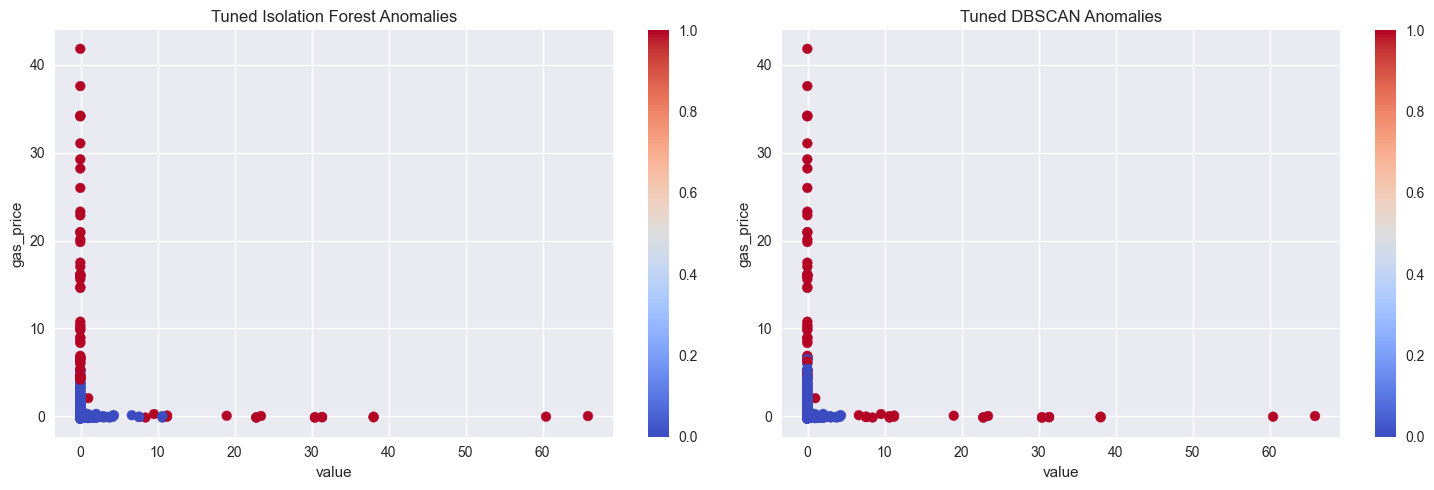

In [23]:
# Visualize results from tuned models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Isolation Forest results
scatter1 = ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], c=if_labels, cmap='coolwarm')
ax1.set_title('Tuned Isolation Forest Anomalies')
ax1.set_xlabel(features_used[0])
ax1.set_ylabel(features_used[1])
plt.colorbar(scatter1, ax=ax1)

# Plot DBSCAN results
scatter2 = ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='coolwarm')
ax2.set_title('Tuned DBSCAN Anomalies')
ax2.set_xlabel(features_used[0])
ax2.set_ylabel(features_used[1])
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

## 4. Anomaly Detection with Default Parameters

In [24]:
# Run both models with default parameters
results_if = anomaly_detection_pipeline(df_processed, model_type="IF")
results_dbscan = anomaly_detection_pipeline(df_processed, model_type="DBSCAN")

In [26]:
def compare_anomalies(df, if_labels, dbscan_labels):
    """
    Compare anomalies detected by Isolation Forest and DBSCAN
    """
    # Create a DataFrame with results
    df_results = df.copy()
    df_results['if_anomaly'] = if_labels
    df_results['dbscan_anomaly'] = dbscan_labels
    
    # Calculate statistics
    anomalies_if = sum(if_labels)
    anomalies_dbscan = sum(dbscan_labels)
    agreement = (if_labels == dbscan_labels).mean() * 100
    
    # Print summary
    print("\nAnomaly Detection Results:")
    print(f"Isolation Forest detected: {anomalies_if} anomalies ({anomalies_if/len(df)*100:.2f}%)")
    print(f"DBSCAN detected: {anomalies_dbscan} anomalies ({anomalies_dbscan/len(df)*100:.2f}%)")
    print(f"Models agree on {agreement:.2f}% of transactions")
    
    # Show example anomalies
    print("\nExample transactions flagged as anomalies by both models:")
    both_anomalies = df_results[(df_results['if_anomaly'] == 1) & (df_results['dbscan_anomaly'] == 1)]
    if len(both_anomalies) > 0:
        display(both_anomalies[['value', 'gas_price', 'transaction_fee']].head())
    else:
        print("No transactions were flagged as anomalies by both models")
    
    return df_results

# Get predictions from both models
if_predictions = if_model.predict(X_scaled)
if_labels = (if_predictions == -1).astype(int)  # Convert to binary (1 for anomalies, 0 for normal)

dbscan_predictions = dbscan_model.fit_predict(X_scaled)
dbscan_labels = (dbscan_predictions == -1).astype(int)  # Convert to binary

# Compare results
results_df = compare_anomalies(df_processed, if_labels, dbscan_labels)


Anomaly Detection Results:
Isolation Forest detected: 179 anomalies (1.00%)
DBSCAN detected: 82 anomalies (0.46%)
Models agree on 99.35% of transactions

Example transactions flagged as anomalies by both models:


,value,gas_price,transaction_fee
166,6.350101e-08,277.690901,3.640361e+07
682,0.000000e+00,16.253656,2.438048e+08
933,0.000000e+00,14.182396,5.792672e+07
943,1.304803e-07,1114.711494,1.437365e+08
1124,2.511711e+02,22.510915,2.025982e+06


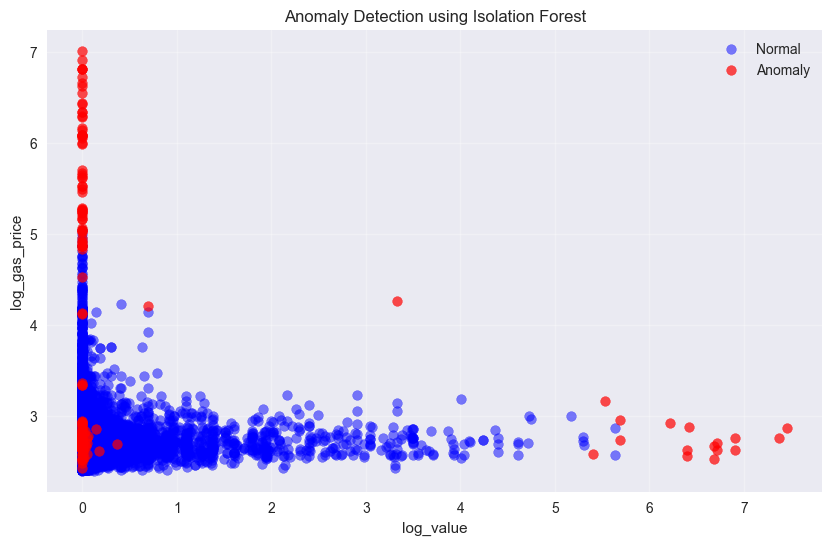

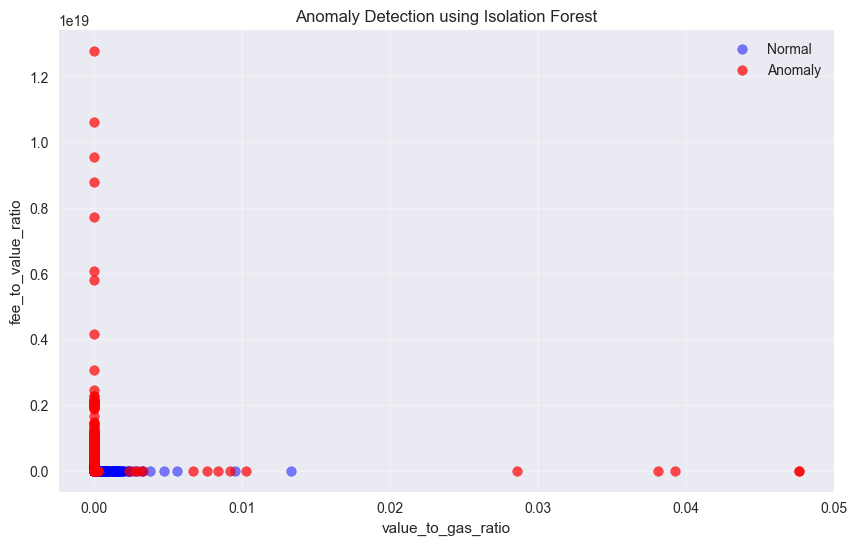

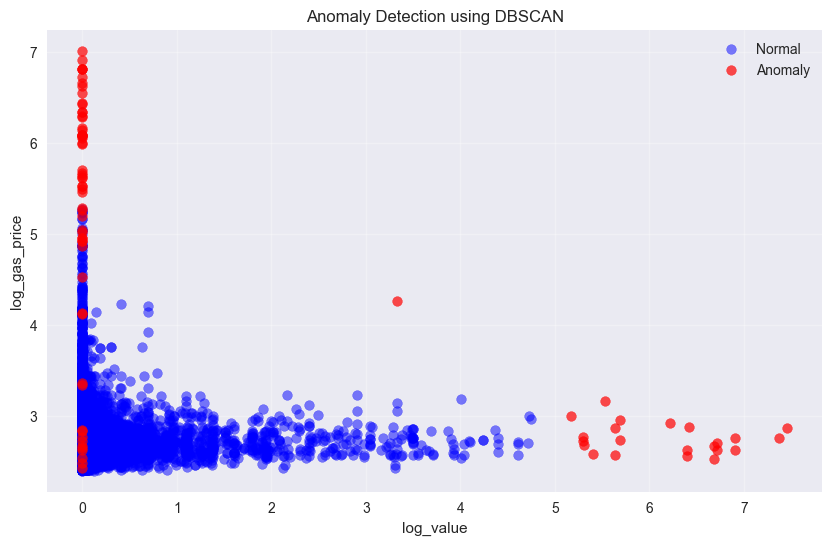

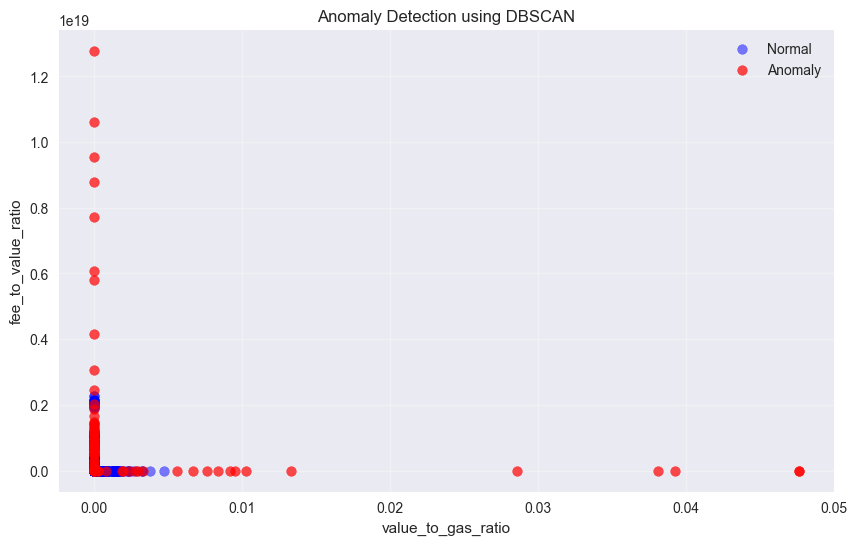

In [28]:
def plot_anomalies(df, x_col, y_col, model_name):
    """
    Plot scatter plot highlighting anomalies for a given model
    """
    plt.figure(figsize=(10, 6))
    
    # Determine which anomaly column to use
    if model_name == 'Isolation Forest':
        anomaly_col = 'if_anomaly'
    else:  # DBSCAN
        anomaly_col = 'dbscan_anomaly'
    
    # Plot normal points
    normal = df[df[anomaly_col] == 0]
    plt.scatter(normal[x_col], normal[y_col], c='blue', label='Normal', alpha=0.5)
    
    # Plot anomalies
    anomalies = df[df[anomaly_col] == 1]
    plt.scatter(anomalies[x_col], anomalies[y_col], c='red', label='Anomaly', alpha=0.7)
    
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Anomaly Detection using {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Create DataFrames with results for each model
results_if = df_processed.copy()
results_if['if_anomaly'] = if_labels

results_dbscan = df_processed.copy()
results_dbscan['dbscan_anomaly'] = dbscan_labels

# Plot for both models
for df, name in [(results_if, 'Isolation Forest'), (results_dbscan, 'DBSCAN')]:
    plot_anomalies(df, 'log_value', 'log_gas_price', name)
    plot_anomalies(df, 'value_to_gas_ratio', 'fee_to_value_ratio', name)

## 5. Analyze Anomalous Transactions

In [30]:
def analyze_anomalies(df, model_name):
    """
    Analyze characteristics of detected anomalies for a given model
    """
    # Determine which anomaly column to use
    if model_name == 'Isolation Forest':
        anomaly_col = 'if_anomaly'
    else:  # DBSCAN
        anomaly_col = 'dbscan_anomaly'
    
    print(f"\nAnalysis of {model_name} Results:")
    
    # Get normal and anomalous transactions
    normal = df[df[anomaly_col] == 0]
    anomalies = df[df[anomaly_col] == 1]
    
    # Calculate percentage of anomalies
    anomaly_pct = len(anomalies) / len(df) * 100
    print(f"Percentage of transactions flagged as anomalies: {anomaly_pct:.2f}%")
    
    # Compare key metrics
    print("\nMean values for key features:")
    for col in ['value', 'gas_price', 'transaction_fee', 'value_to_gas_ratio', 'fee_to_value_ratio']:
        print(f"\n{col}:")
        print(f"  Normal: {normal[col].mean():.2f}")
        print(f"  Anomalous: {anomalies[col].mean():.2f}")
        print(f"  Ratio (Anomalous/Normal): {anomalies[col].mean() / normal[col].mean():.2f}")

# Analyze results for both models
analyze_anomalies(results_if, "Isolation Forest")
analyze_anomalies(results_dbscan, "DBSCAN")


Analysis of Isolation Forest Results:
Percentage of transactions flagged as anomalies: 1.00%

Mean values for key features:

value:
  Normal: 0.44
  Anomalous: 66.91
  Ratio (Anomalous/Normal): 153.16

gas_price:
  Normal: 14.65
  Anomalous: 133.44
  Ratio (Anomalous/Normal): 9.11

transaction_fee:
  Normal: 2587982.61
  Anomalous: 122139622.32
  Ratio (Anomalous/Normal): 47.19

value_to_gas_ratio:
  Normal: 0.00
  Anomalous: 0.00
  Ratio (Anomalous/Normal): 114.40

fee_to_value_ratio:
  Normal: 17938981108620220.00
  Anomalous: 1070482860850226432.00
  Ratio (Anomalous/Normal): 59.67

Analysis of DBSCAN Results:
Percentage of transactions flagged as anomalies: 0.46%

Mean values for key features:

value:
  Normal: 0.36
  Anomalous: 162.33
  Ratio (Anomalous/Normal): 451.89

gas_price:
  Normal: 14.76
  Anomalous: 249.98
  Ratio (Anomalous/Normal): 16.94

transaction_fee:
  Normal: 3136793.81
  Anomalous: 144863310.46
  Ratio (Anomalous/Normal): 46.18

value_to_gas_ratio:
  Normal: 0.

## 6. Save Results

In [32]:
# Combine results from both models
final_df = df_processed.copy()
final_df['anomaly_if'] = results_if['if_anomaly']  # Using if_anomaly instead of anomaly_label
final_df['anomaly_dbscan'] = results_dbscan['dbscan_anomaly']  # Using dbscan_anomaly instead of anomaly_label

# Add a column for agreement between models
final_df['models_agree'] = final_df['anomaly_if'] == final_df['anomaly_dbscan']

# Analyze agreement
total_agreement = final_df['models_agree'].mean() * 100
both_anomaly = ((final_df['anomaly_if'] == 1) & (final_df['anomaly_dbscan'] == 1)).sum()
either_anomaly = ((final_df['anomaly_if'] == 1) | (final_df['anomaly_dbscan'] == 1)).sum()

print("Model Agreement Analysis:")
print(f"Models agree on {total_agreement:.2f}% of transactions")
print(f"Transactions flagged as anomalies by both models: {both_anomaly}")
print(f"Transactions flagged as anomalies by at least one model: {either_anomaly}")

# Show some example transactions where models disagree
print("\nExample transactions where models disagree:")
disagreements = final_df[~final_df['models_agree']].head()
display(disagreements[['value', 'gas_price', 'transaction_fee', 'anomaly_if', 'anomaly_dbscan']])

Model Agreement Analysis:
Models agree on 99.35% of transactions
Transactions flagged as anomalies by both models: 73
Transactions flagged as anomalies by at least one model: 188

Example transactions where models disagree:


,value,gas_price,transaction_fee,anomaly_if,anomaly_dbscan
105,0.058325,15.051617,7.525808e+07,1,0
270,0.000000,14.381958,2.157294e+08,1,0
347,0.000000,17.200807,8.600404e+07,1,0
678,0.000000,17.253656,8.626828e+07,1,0
1270,0.000000,14.381958,2.157294e+08,1,0
